## Imports

In [136]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import requests
import zipfile as zpf
from tqdm import tqdm

## netCDF files: Processing & exploration

In [2]:
folder = "/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/"

In [3]:
files = [path.join(folder, file) for file in listdir(folder)]
print(files)

['/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00034.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00142.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00151.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00280.nc']


In [4]:
ds = xr.open_dataset(files[0])

In [5]:
ds

<xarray.Dataset>
Dimensions:                               (nPoints_XY: 7857, nPoints_XYZ: 7857, nMetLines: 8760, nGroups: 1, nDatasets: 6, OutputOptionsUsed: 3, NumberOfTypesOfOutputPoint: 5)
Dimensions without coordinates: nPoints_XY, nPoints_XYZ, nMetLines, nGroups, nDatasets, OutputOptionsUsed, NumberOfTypesOfOutputPoint
Data variables: (12/24)
    PointX_XY                             (nPoints_XY) float32 ...
    PointY_XY                             (nPoints_XY) float32 ...
    PointName_XY                          (nPoints_XY) |S44 ...
    PointX_XYZ                            (nPoints_XYZ) float32 ...
    PointY_XYZ                            (nPoints_XYZ) float32 ...
    PointZ_XYZ                            (nPoints_XYZ) float32 ...
    ...                                    ...
    Dataset5                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Dataset6                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Output_Options_Description            (OutputOptionsUsed) |S14 ...
    Output_Options_Used                   (OutputOptionsUsed) int32 ...
    Output_Points_Type                    (NumberOfTypesOfOutputPoint) |S16 ...
    Number_Of_Output_Points_Of_Each_Type  (NumberOfTypesOfOutputPoint) int32 ...
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

There is a Dataset for each pollutant species, e.g. the NO2 data is contained in `Dataset2`.

Each pollutant dataset has a time dimension, represented by met lines, and a space dimension, represented by XYZ point number. Each pollutant dataset also has a Groups dimension, which indicates a subset of emission sources (here there is only one Group, for "All sources").

To identify the timestamp from the met lines, a separate `Met_Line` dataset contains timestamps encoded as YYYY_DDD_HH, with days numbered from 1 to 365.

To identify the spatial coordinates (OSGB (British National Grid)), the `PointX_XYZ`, `PointY_XYZ`, and `PointZ_XYZ` datasets contain the X, Y, and Z coordinates respectively.

The DataArray can be indexed like a `numpy` array e.g. to obtain only the concentrations through time at one spatial point e.g. `NO2_da[:,0,0].values`.

The DataArray can also be averaged over a dimension like a `numpy` array e.g. spatially averaged timeseries: `NO2_da.mean(axis=2).squeeze().values`. The `.squeeze()` function squeezes out the Groups dimension, since it has size 1.

### Time

Let's extract the datetime information from the Met_Line dataset:

In [6]:
def metline_to_datetime(i):
    numbers = str(i).replace("b", "").replace("'", "").split("_")
    return np.datetime64(f"{numbers[0]}")+ np.timedelta64(int(numbers[1])-1, "D") + np.timedelta64(int(numbers[2]), "h")

def extract_dataset_time_axis(ds):
    datetime_index = []
    for i in ds.Met_Line.values:
        datetime_index.append(metline_to_datetime(i))
    return datetime_index

In [7]:
datetime_index = extract_dataset_time_axis(ds)

Now we can plot a spatial average timeseries for NO2:

In [8]:
def plot_timeseries(dataframe, columns, title, units, figure_size=(8,4)):
    plt.figure(figsize=figure_size, dpi=300)
    for column in columns:
        dataframe[column].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

Missing values are assigned as `-999` during ADMS-Urban modelling, so we replace these with NaNs.
NOTE: I think there aren't actually any -999 values in the data, just some really high concentrations.

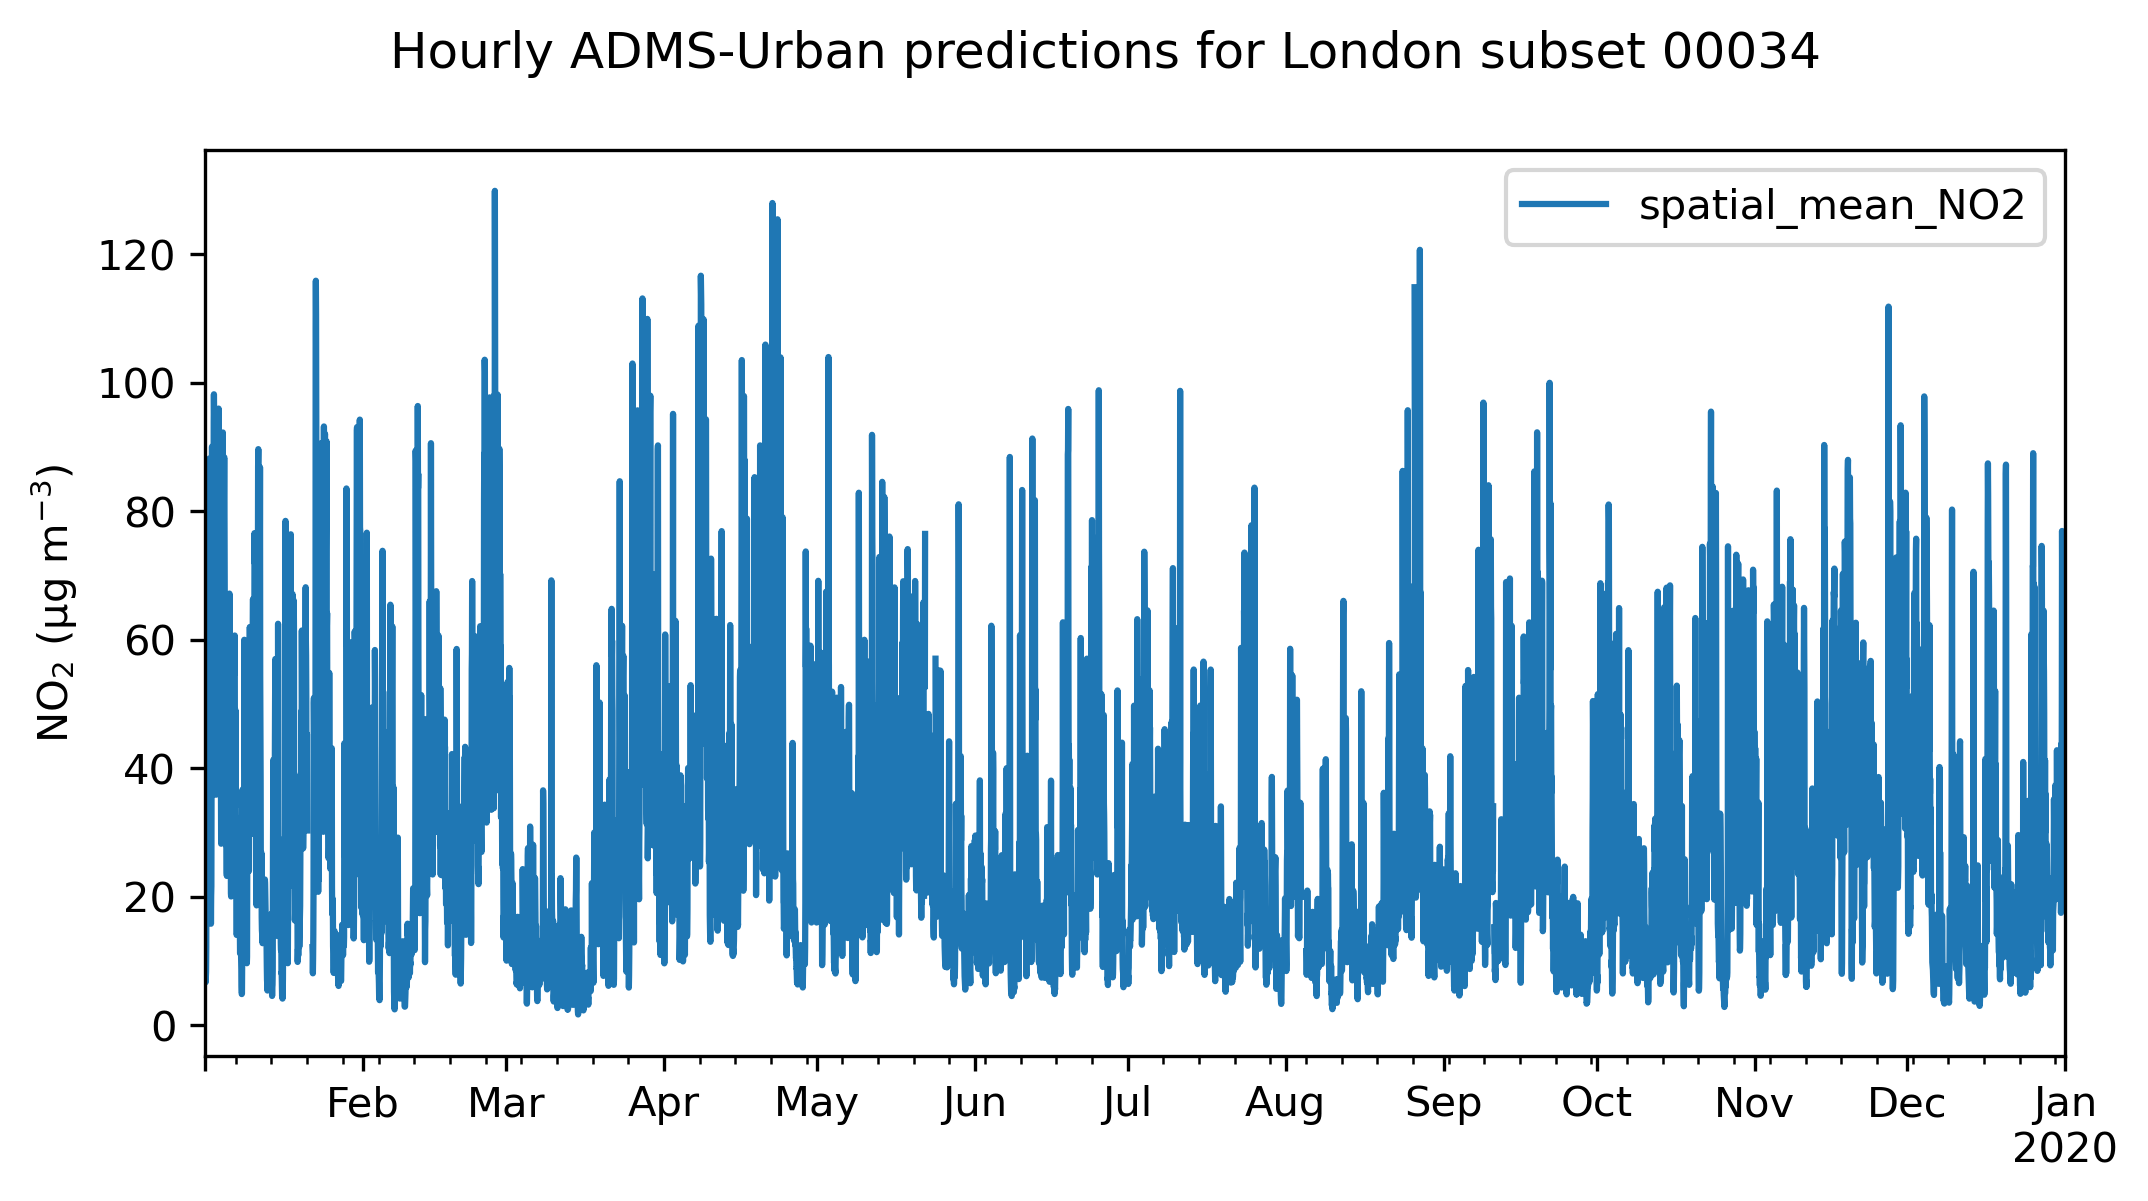

In [9]:
plot_timeseries(dataframe=pd.DataFrame(ds.Dataset2.mean(axis=2).squeeze().values, index=datetime_index, columns=["spatial_mean_NO2"]).replace(-999, np.nan), 
                columns=["spatial_mean_NO2"], 
                title="Hourly ADMS-Urban predictions for London subset 00034", 
                units="NO$_2$ (µg m$^{-3}$)")

### Space

The `PyBNG` library enables interconversion between the Ordnance Survey British National Grid (OS BNG) coordinates and latitude/longitude coordinates, which will be more useful for plotting and further analysis.

In [ ]:
def PointXYZ_to_latlon(PointXs, PointYs):
    df = pd.DataFrame()
    for X, Y in zip(PointXs.astype(int), PointYs.astype(int)):
        latlon = PyBNG(easting=X, northing=Y).get_latlon()
        df = df.append([latlon])
    df.columns = ["latitude", "longitude"]
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
latlon_df = PointXYZ_to_latlon(ds.PointX_XYZ.values, 
                                  ds.PointY_XYZ.values)
gdf = gpd.GeoDataFrame(latlon_df, geometry=gpd.points_from_xy(latlon_df.longitude, latlon_df.latitude))

gdf.plot()

To plot this on a map of London, we can download the London borough GIS boundaries from the London Datastore:

In [ ]:
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
tmp_folder = path.join(path.abspath(""), "tmp")
filename = path.basename(url)
filepath = path.join(tmp_folder, filename)

In [ ]:
new_download = False

if new_download:
    file = open(filepath, 'wb')
    file.write(requests.get(url).content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(tmp_folder)

Load the London Boroughs shapefile and convert to the latitude/longitude coordinate system by referencing the EPSG code `4326`:

In [ ]:
shapefilepath = path.join(tmp_folder, "statistical-gis-boundaries-london", "ESRI",
                         "London_Borough_Excluding_MHW.shp")
london_boroughs_gdf = gpd.read_file(shapefilepath).to_crs(epsg=4326)

In [ ]:
def plot_on_map(data_geodataframe, map_geodataframe, column=None, title="Greater London", fontsize="25", figsize=(20,10), data_color=None, data_cmap=None, colorbar=False, data_markersize=0.1, map_color="whitesmoke", map_edge_color="black", axis="off"):
    data_geodataframe.plot(column=column, ax=map_geodataframe.plot(figsize=figsize, color=map_color, edgecolor=map_edge_color),
                          color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=plt.Normalize(data_geodataframe[column].min(), data_geodataframe[column].max()))).set_label(column)
    plt.suptitle(title, fontsize=fontsize)
    plt.axis(axis)
    plt.show()

In [ ]:
plot_on_map(gdf, london_boroughs_gdf, data_color="tab:orange")

Calculate the 2019 annual average NO2 concentration at each output point and join the GeoDataFrame with the spatial points:

In [ ]:
space_gdf = gpd.GeoDataFrame(ds.Dataset2.mean(axis=0).squeeze().values, 
                  index=gdf.index, 
                  columns=["2019_mean_NO2"]).join(gdf)

In [ ]:
def plot_in_grid_box(geodataframe, column, title, figsize=(10,5), markersize=0.1, cmap="plasma_r", colorbar=True, edgecolor=None):
    geodataframe.plot(column=column, figsize=figsize, markersize=markersize, cmap=cmap, edgecolor=edgecolor)
    plt.colorbar(
        plt.cm.ScalarMappable(
            cmap=cmap, 
            norm=plt.Normalize(geodataframe[column].min(), geodataframe[column].max())))
    plt.suptitle(title)
    plt.show()

In [ ]:
plot_in_grid_box(space_gdf, "2019_mean_NO2", title="2019 annual mean NO$_2$ (subset output)")

In [ ]:
plot_on_map(space_gdf, london_boroughs_gdf, column="2019_mean_NO2", data_cmap="plasma_r")

### New Dataset

We can make a new Dataset containing all of the pollutant concentrations, as well as meteorological variables:

In [21]:
def process_dataset(ds):
    data_variables = {
        "NOx": (["time", "space"], ds.Dataset1.values.squeeze(), ds.Dataset1.attrs),
        "NO2": (["time", "space"], ds.Dataset2.values.squeeze(), ds.Dataset2.attrs),
        "PM10": (["time", "space"], ds.Dataset3.values.squeeze(), ds.Dataset3.attrs),
        "PM2.5": (["time", "space"], ds.Dataset4.values.squeeze(), ds.Dataset4.attrs),
        "CO2": (["time", "space"], ds.Dataset5.values.squeeze(), ds.Dataset5.attrs),
        "O3": (["time", "space"], ds.Dataset6.values.squeeze(), ds.Dataset6.attrs),
        "wind_speed_at_10m": (["time"], ds.Met_UAt10m.values.squeeze(), ds.Met_UAt10m.attrs),
        "wind_direction": (["time"], ds.Met_PHI.values.squeeze(), ds.Met_PHI.attrs)
                     }

    coords = {"datetime": (["time"], np.array(extract_dataset_time_axis(ds))),
         "latitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).latitude.values),
         "longitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).longitude.values)}

    attrs = ds.attrs

    return xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

Let's try loading multiple netCDF files:

In [22]:
files

['/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00034.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00142.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00151.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00280.nc']

We concatentate the xarray datasets along the `space` dimension:

In [23]:
new_ds = xr.concat([process_dataset(xr.open_dataset(file)) for file in files], "space")

In [24]:
new_ds

<xarray.Dataset>
Dimensions:            (time: 8760, space: 20025)
Coordinates:
    datetime           (time) datetime64[ns] 2019-01-01T01:00:00 ... 2020-01-01
    latitude           (space) float64 51.39 51.39 51.39 ... 51.44 51.44 51.44
    longitude          (space) float64 -0.2417 -0.2389 ... -0.2443 -0.2435
Dimensions without coordinates: time, space
Data variables:
    NOx                (time, space) float32 11.57 11.06 10.81 ... 62.24 72.23
    NO2                (time, space) float32 11.0 10.73 10.53 ... 44.66 47.33
    PM10               (time, space) float32 11.24 11.15 11.13 ... 43.48 45.53
    PM2.5              (time, space) float32 7.793 7.752 7.745 ... 33.37 34.33
    CO2                (time, space) float32 5.543e+03 5.192e+03 ... 3.353e+04
    O3                 (time, space) float32 60.41 60.52 ... 0.08722 0.08145
    wind_speed_at_10m  (space, time) float32 1.98 3.236 2.297 ... 2.9 1.962 1.36
    wind_direction     (space, time) float32 275.8 286.1 289.2 ... 110.5 130.1
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

Now we can make a Geopandas Dataframe for plotting:

In [25]:
new_gdf = gpd.GeoDataFrame(new_ds.NO2.mean(axis=0).values, 
                 columns=["2019_mean_NO2"], 
                 geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))

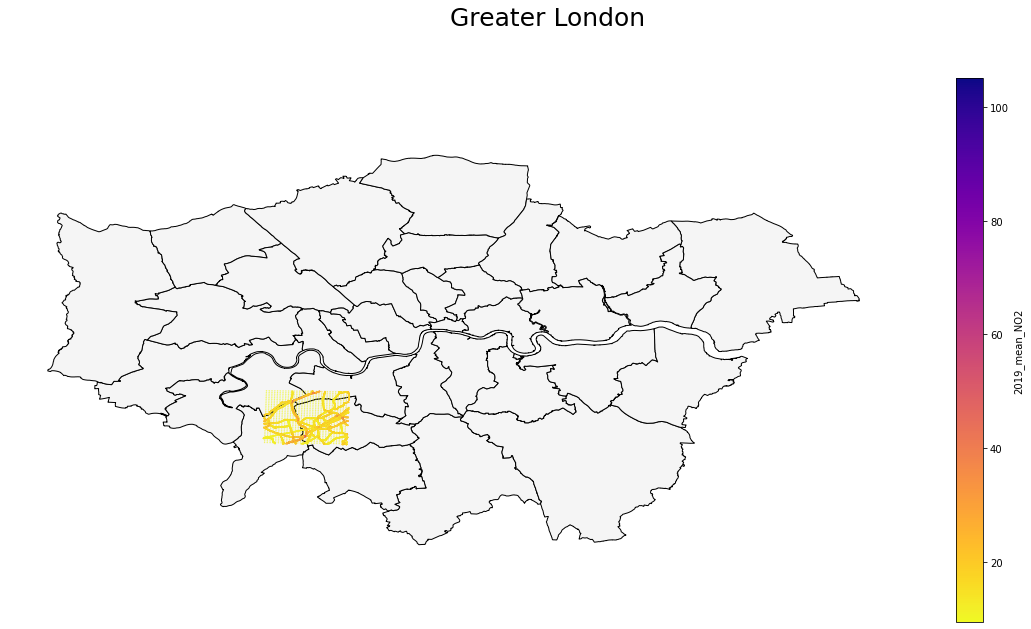

In [26]:
plot_on_map(new_gdf, london_boroughs_gdf, column="2019_mean_NO2", 
            data_cmap="plasma_r", colorbar=True)

#### Re-gridding

So I'm currently using a dataset which is indexed by time and space i.e. my spatial dimension is a long list of coordinates indexed by longitude-latitude, rather than with longitude and latitude indexed separately so that the space is 2D.

How can I reshape the pollutant concentration data so that it can be indexed on a grid?

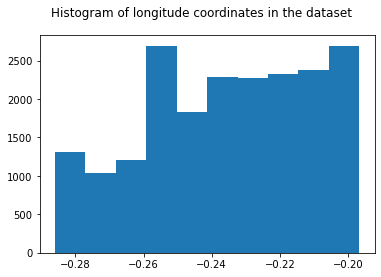

In [27]:
plt.hist(new_ds.longitude.values)
plt.suptitle("Histogram of longitude coordinates in the dataset")
plt.show()

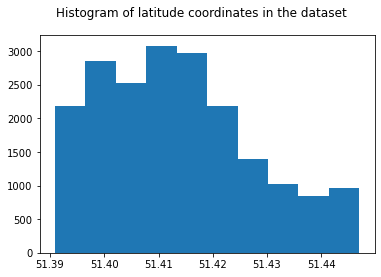

In [28]:
plt.hist(new_ds.latitude.values)
plt.suptitle("Histogram of latitude coordinates in the dataset")
plt.show()

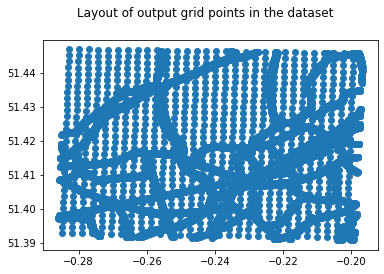

In [29]:
new_gdf.plot()
plt.suptitle("Layout of output grid points in the dataset")
plt.show()

Let's try gridding the data.

Adapted from [this tutorial](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [72]:
xmin, ymin, xmax, ymax = new_gdf.total_bounds
n_cells = 27
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

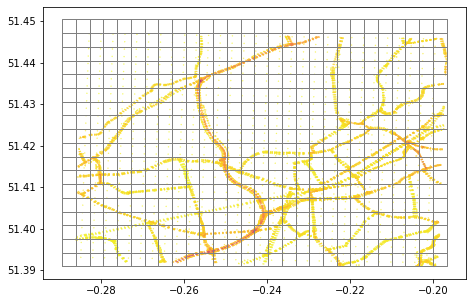

In [73]:
cell.plot(ax=new_gdf.plot(markersize=0.1, column="2019_mean_NO2", cmap="plasma_r", figsize=(10,5)), 
          facecolor="none", edgecolor="grey")
plt.show()

Merge the grid with the data points themselves:

In [74]:
merged_gdf = gpd.sjoin(new_gdf, cell, how="left", predicate="within")

Use the `.dissolve()` function to upsample the data to the grid:

In [75]:
dissolve = merged_gdf.dissolve(by="index_right", aggfunc="mean")
cell.loc[dissolve.index, "2019_mean_NO2"] = dissolve["2019_mean_NO2"].values

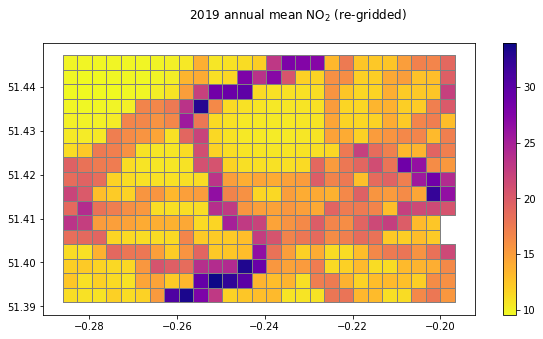

In [76]:
plot_in_grid_box(cell, "2019_mean_NO2", "2019 annual mean NO$_2$ (re-gridded)", edgecolor="grey")

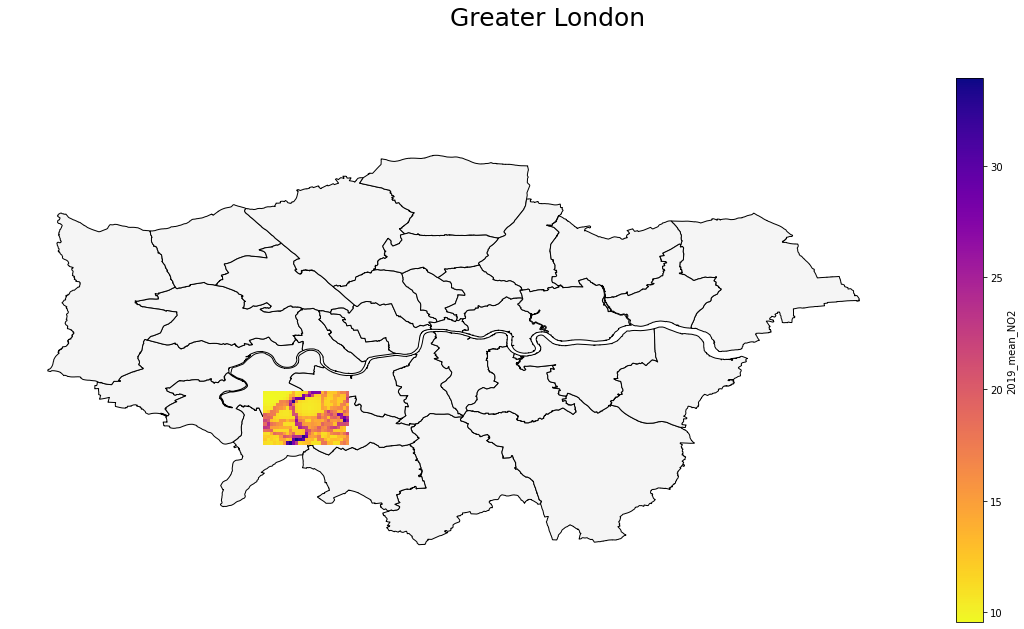

In [77]:
plot_on_map(cell, london_boroughs_gdf, column="2019_mean_NO2", data_cmap="plasma_r", colorbar=True)

This 2019 annual mean data can be reshaped and made into an `xarray` dataset:

In [39]:
data_variables = {"NO2": (["longitude", "latitude"], cell["2019_mean_NO2"].values.reshape(28, 18), new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], cell.centroid.x.drop_duplicates()),
            "latitude": (["latitude"], cell.centroid.y.drop_duplicates())}
     
attrs = new_ds.attrs

NO2_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

In [40]:
NO2_ds

<xarray.Dataset>
Dimensions:    (longitude: 28, latitude: 18)
Coordinates:
  * longitude  (longitude) float64 -0.2877 -0.2844 -0.2811 ... -0.2016 -0.1983
  * latitude   (latitude) float64 51.39 51.4 51.4 51.4 ... 51.44 51.45 51.45
Data variables:
    NO2        (longitude, latitude) float64 nan nan nan nan ... 19.68 19.03 nan
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

#### Timeseries re-gridding

For the processed timeseries `xarray` dataset, we need to re-grid each timestep and then reshape it...

In [97]:
new_ds.datetime

<xarray.DataArray 'datetime' (time: 8760)>
array(['2019-01-01T01:00:00.000000000', '2019-01-01T02:00:00.000000000',
       '2019-01-01T03:00:00.000000000', ...,
       '2019-12-31T22:00:00.000000000', '2019-12-31T23:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    datetime  (time) datetime64[ns] 2019-01-01T01:00:00 ... 2020-01-01
Dimensions without coordinates: time

In [42]:
new_ds.NO2.values.shape

(8760, 20025)

I could loop through each time step and use `geopandas` to convert to a lat/lon grid, then stack the timesteps into a `numpy` array to then make into an `xarray` dataset:

In [155]:
xmin, ymin, xmax, ymax = gpd.points_from_xy(new_ds.longitude.values, 
                                            new_ds.latitude.values).total_bounds
n_cells = 27
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

ref_cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

In [156]:
cell_list = []
progress_bar = tqdm(range(0, new_ds.datetime.shape[0]))

for i in progress_bar:
    progress_bar.set_description(f"Gridding timesteps")
    cell = ref_cell.copy()
    timestep_gdf = gpd.GeoDataFrame(new_ds.NO2[i, :].values, 
                     columns=["timestep_NO2"], 
                     geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
    merge = gpd.sjoin(timestep_gdf, ref_cell, how="left", predicate="within")
    dissolve = merge.dissolve(by="index_right", aggfunc="mean")
    cell.loc[dissolve.index, "timestep_NO2"] = dissolve["timestep_NO2"].values
    cell_list.append(cell["timestep_NO2"].values.reshape(28,18))

Gridding timestep 8759 of 8760.: 100%|██████████| 8760/8760 [4:10:09<00:00,  1.71s/it]  


In [157]:
timeseries_gridded = np.stack(cell_list, axis=-1)

timeseries_gridded.shape

(28, 18, 8760)

In [158]:
data_variables = {"NO2": (["longitude", "latitude", "time"], timeseries_gridded, new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], ref_cell.centroid.x.drop_duplicates()),
            "latitude": (["latitude"], ref_cell.centroid.y.drop_duplicates()),
         "time": (["time"], new_ds.datetime.data)}
     
attrs = new_ds.attrs

NO2_timeseries_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

In [159]:
NO2_timeseries_ds.to_netcdf(path.join(folder, "NO2_timeseries_grid.nc"))

Cycling through all the pollutant species:

In [ ]:
for variable in new_ds.data_vars:
    print(variable)

    # Grid the timeseries data
    cell_list = []
    progress_bar = tqdm(range(0, new_ds.datetime.shape[0]))

    for i in progress_bar:
        progress_bar.set_description(f"Gridding timesteps")
        cell = ref_cell.copy()
        timestep_gdf = gpd.GeoDataFrame(new_ds[variable][i, :].values, 
                         columns=[f"timestep_{variable}"], 
                         geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
        merge = gpd.sjoin(timestep_gdf, ref_cell, how="left", predicate="within")
        dissolve = merge.dissolve(by="index_right", aggfunc="mean")
        cell.loc[dissolve.index, f"timestep_{variable}"] = dissolve[f"timestep_{variable}"].values
        cell_list.append(cell[f"timestep_{variable}"].values.reshape(28,18))

    # Stack the grids into a numpy array
    timeseries_gridded = np.stack(cell_list, axis=-1)

    # Create the xarray dataset
    data_variables = {f"{variable}": (["longitude", "latitude", "time"], timeseries_gridded, new_ds[variable].attrs)
                        }

    coords = {"longitude": (["longitude"], ref_cell.centroid.x.drop_duplicates()),
                "latitude": (["latitude"], ref_cell.centroid.y.drop_duplicates()),
             "time": (["time"], new_ds.datetime.data)}

    attrs = new_ds.attrs

    timeseries_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

    # Save to a netCDF file
    filepath = path.join(folder, f"{variable}_timeseries_grid.nc")
    timeseries_ds.to_netcdf(filepath)
    print(f"Saved to {filepath}.")

Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

NOx


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/NOx_timeseries_grid.nc.
NO2


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/NO2_timeseries_grid.nc.
PM10


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/PM10_timeseries_grid.nc.
PM2.5


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/PM2.5_timeseries_grid.nc.
CO2


Gridding timesteps:   6%|▌         | 508/8760 [13:34<3:31:00,  1.53s/it]